In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import probplot
from IPython.display import display, Math
from numpyarray_to_latex.jupyter import to_ltx
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-muted', 'practicals.mplstyle'])
def pprint(*args):
    res = ""
    for i in args:
        if type(i) == np.ndarray:
            res += to_ltx(i, brackets='[]')
        elif type(i) == str:
            res += i
    display(Math(res))

In [2]:
np.random.seed(123)

N = 200
sigma_true = 2.0

beta_true = np.array([5.0, 1.5, -2.0, 0.5])

X1 = np.random.uniform(-5, 5, size=N)
X2 = np.random.uniform(-10, 10, size=N)
X3 = np.random.normal(0, 2, size=N)

df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3})

Y_true = (beta_true[0]
          + beta_true[1]*df['X1']
          + beta_true[2]*df['X2']
          + beta_true[3]*df['X3'])

noise = np.random.normal(0, sigma_true, size=N)
df['Y'] = Y_true + noise

df.head()

,X1,X2,X3,Y
0,1.964692,0.852719,-3.510804,5.687964
1,-2.138607,-8.664511,-0.697215,16.509223
2,-2.731485,3.067297,-0.385230,-4.050829
3,0.513148,9.921727,0.898271,-12.453060
4,2.194690,5.387947,-0.290727,-1.697682


               X1          X2          X3           Y
count  200.000000  200.000000  200.000000  200.000000
mean     0.032708   -0.193044   -0.112239    5.572700
std      2.663947    5.907073    1.963533   12.473036
min     -4.973119   -9.929356   -5.262876  -20.342999
25%     -1.953937   -5.254828   -1.286318   -4.258475
50%      0.207716   -0.714124   -0.101728    5.417761
75%      2.181854    5.168943    1.206797   14.861563
max      4.953585    9.921727    4.501352   30.849943


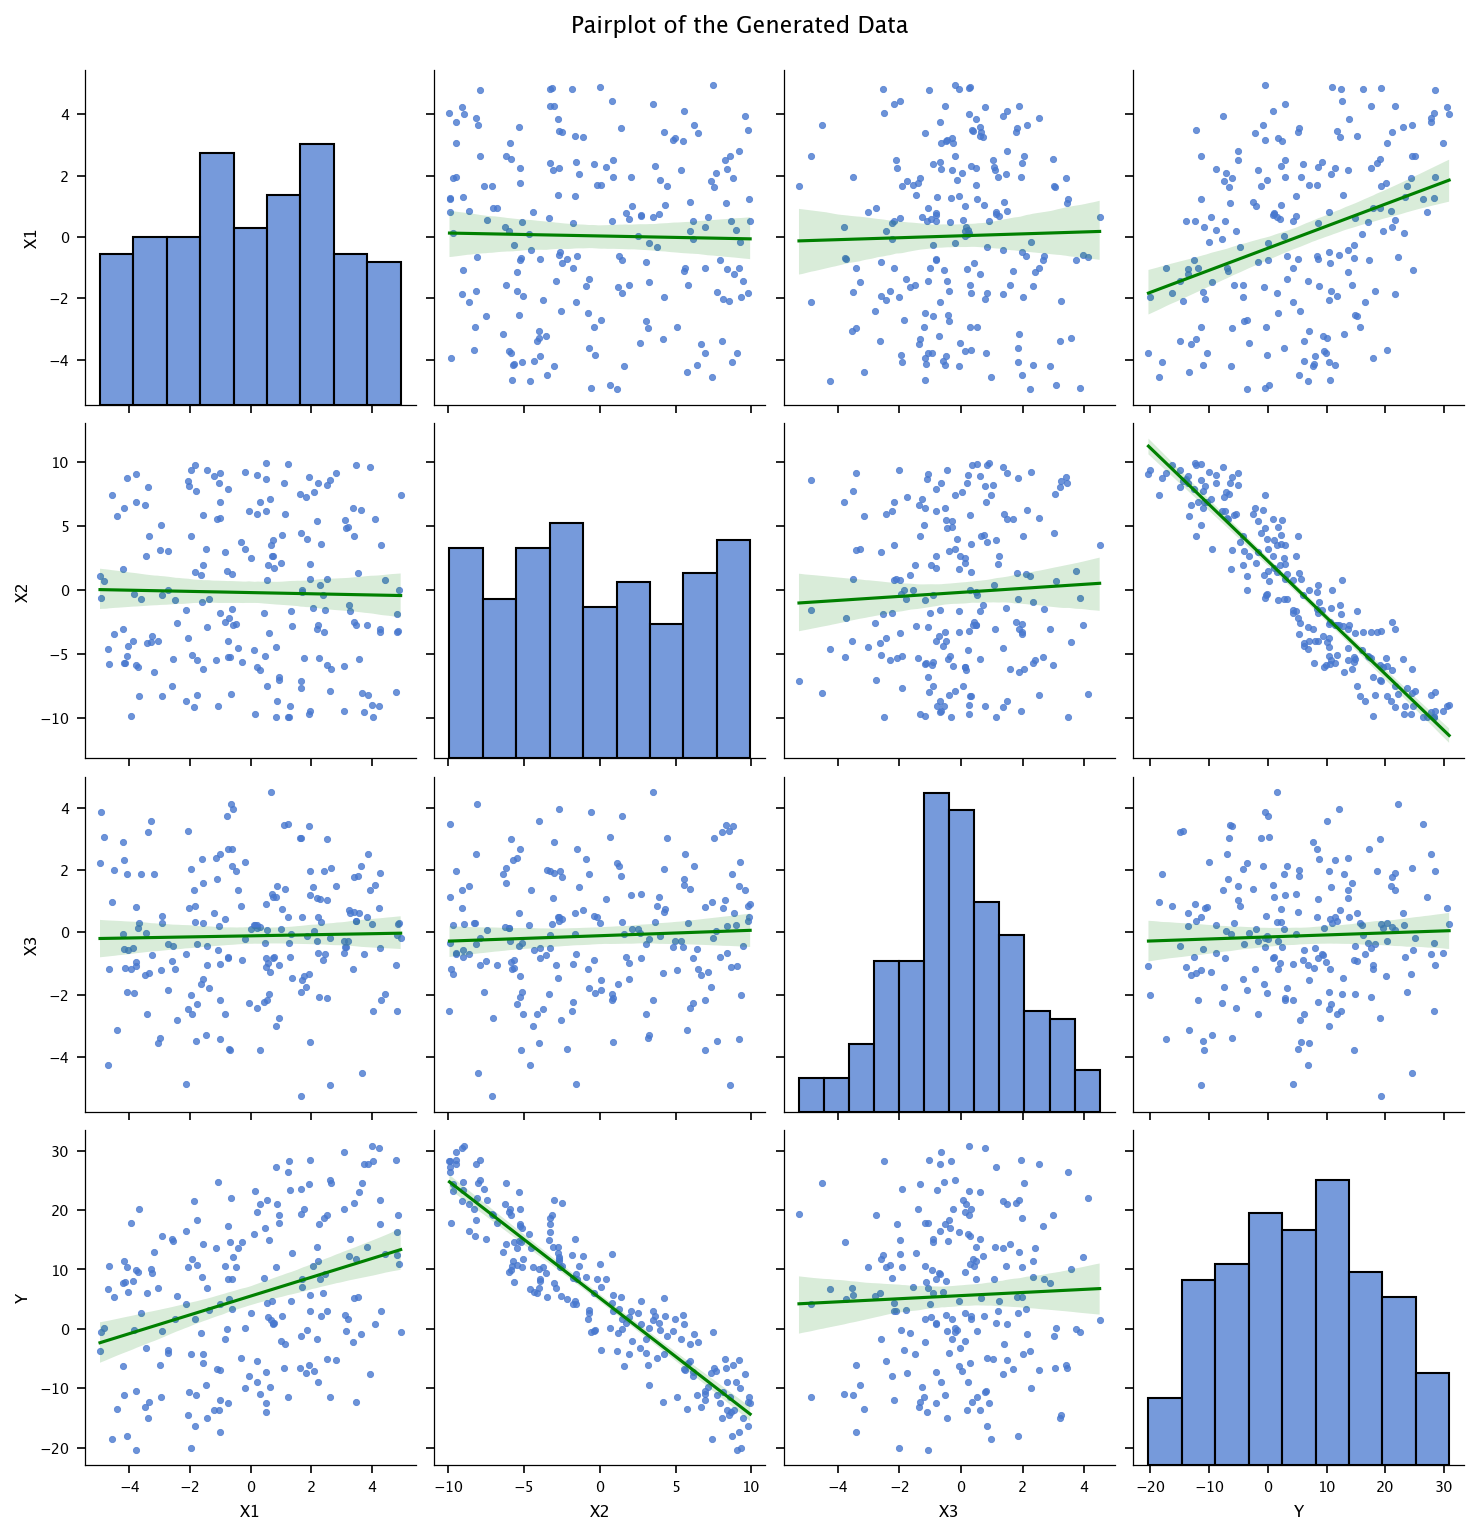

In [3]:
print(df.describe())
sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'green'}})
plt.suptitle("Pairplot of the Generated Data", y=1.02)
plt.show()

In [4]:
X_mat = np.column_stack([
    np.ones(N),
    df['X1'].values,
    df['X2'].values,
    df['X3'].values
]) 

y_vec = df['Y'].values.reshape(-1,1)

print("X_mat shape:", X_mat.shape)
print("y_vec shape:", y_vec.shape)

X_mat shape: (200, 4)
y_vec shape: (200, 1)


In [5]:
XTX = X_mat.T @ X_mat
XTX_inv = np.linalg.inv(XTX)
XTy = X_mat.T @ y_vec
beta_hat_manual = XTX_inv @ XTy

beta_hat_manual = beta_hat_manual.flatten()

pprint("\\text{Manual OLS estimates}:", beta_hat_manual)
pprint("\\text{True coefficients}:", beta_true)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
X_design_sm = sm.add_constant(df[['X1','X2','X3']])
model_ols = sm.OLS(df['Y'], X_design_sm).fit()
print(model_ols.summary())

beta_hat_sm = model_ols.params.values
print("statsmodels OLS:", beta_hat_sm)
print("Manual OLS:", beta_hat_manual)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2657.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          2.01e-158
Time:                        17:34:04   Log-Likelihood:                -415.03
No. Observations:                 200   AIC:                             838.1
Df Residuals:                     196   BIC:                             851.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2043      0.138     37.720      0.0

In [7]:
residuals = model_ols.resid
fitted_vals = model_ols.fittedvalues

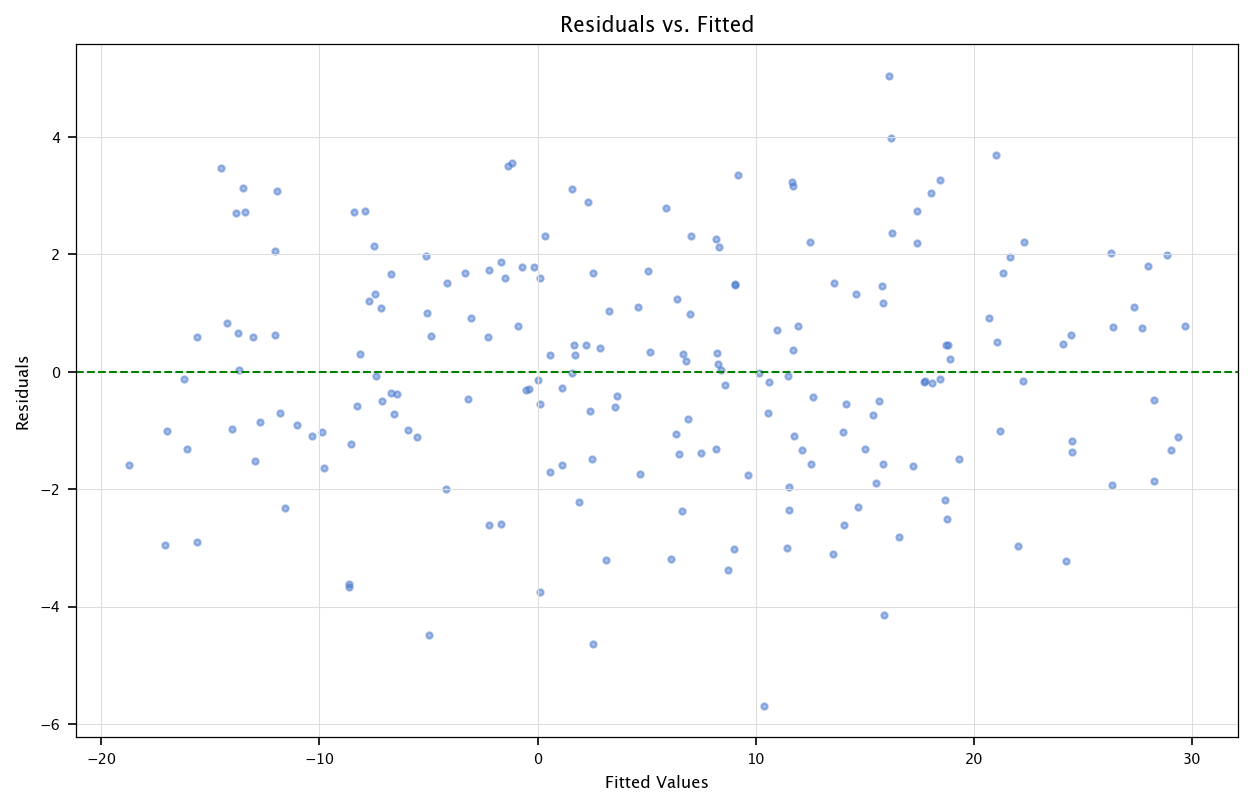

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='green', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.grid("on")
plt.show()

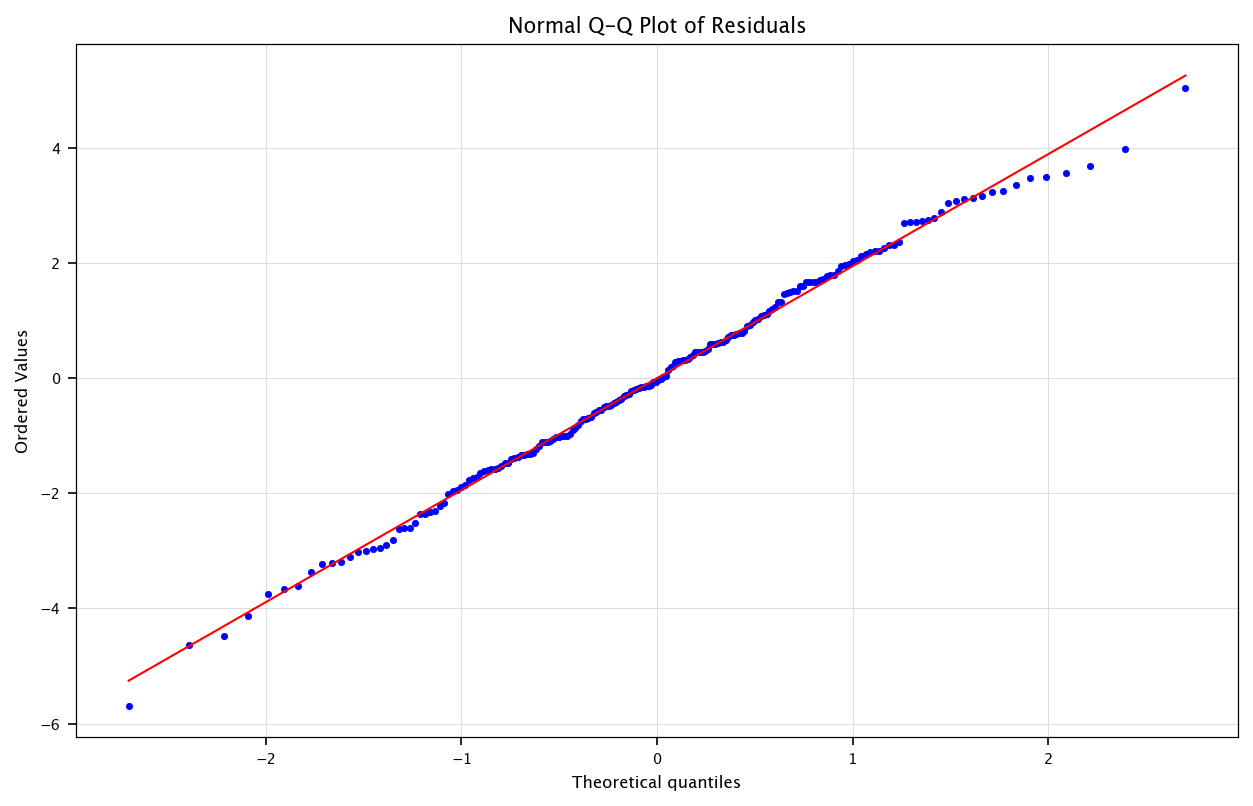

In [9]:
plt.figure(figsize=(10, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Residuals")
plt.grid("on")
plt.show()

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['X1','X2','X3']])
print("Original shape:", df[['X1','X2','X3']].shape)
print("Polynomial shape:", X_poly.shape)

X_poly_mat = np.column_stack([np.ones(N), X_poly])

Original shape: (200, 3)
Polynomial shape: (200, 9)


In [11]:
XTX_poly = X_poly_mat.T @ X_poly_mat
XTX_poly_inv = np.linalg.inv(XTX_poly)
XTy_poly = X_poly_mat.T @ y_vec
beta_hat_poly_manual = XTX_poly_inv @ XTy_poly
beta_hat_poly_manual = beta_hat_poly_manual.flatten()

print("Manual OLS (polynomial) shape of beta:", beta_hat_poly_manual.shape)
pprint("\\text{beta\_hat\_poly\_manual}:", beta_hat_poly_manual)

Manual OLS (polynomial) shape of beta: (10,)


<IPython.core.display.Math object>

In [12]:
X_poly_sm = sm.add_constant(X_poly)
model_poly_sm = sm.OLS(df['Y'], X_poly_sm).fit()
beta_hat_poly_sm = model_poly_sm.params.values

pprint("\\text{Statsmodels polynomial OLS}:", beta_hat_poly_sm)
pprint("\\text{Manual polynomial OLS}:", beta_hat_poly_manual)
print("\nPolynomial OLS summary:\n", model_poly_sm.summary())

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Polynomial OLS summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     872.4
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          2.13e-149
Time:                        17:34:05   Log-Likelihood:                -413.46
No. Observations:                 200   AIC:                             846.9
Df Residuals:                     190   BIC:                             879.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0526     

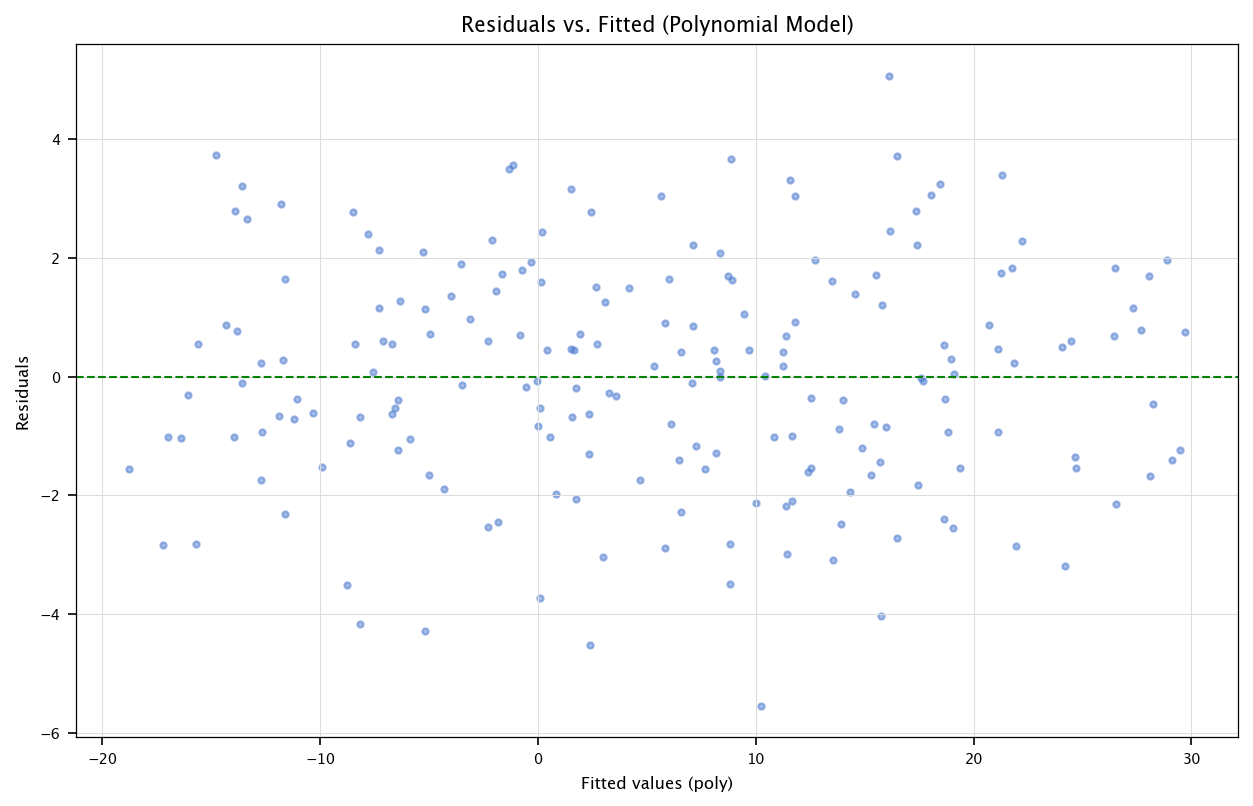

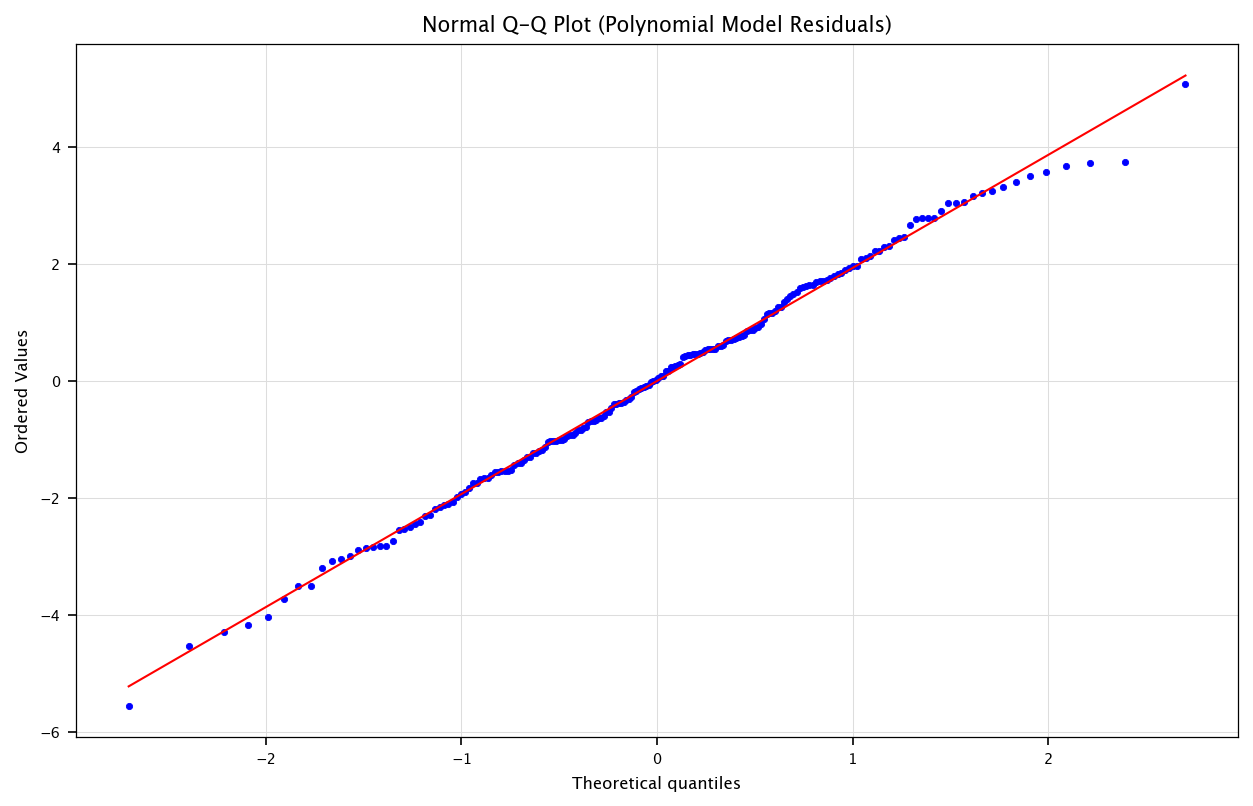

In [13]:
residuals_poly = model_poly_sm.resid
fitted_poly = model_poly_sm.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_poly, residuals_poly, alpha=0.5)
plt.axhline(y=0, color='green', linestyle='--')
plt.xlabel("Fitted values (poly)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Polynomial Model)")
plt.grid("on")
plt.show()

plt.figure(figsize=(10, 6))
probplot(residuals_poly, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot (Polynomial Model Residuals)")
plt.grid("on")
plt.show()

RBF-transformed shape: (200, 50)
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     146.9
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          5.70e-105
Time:                        17:34:05   Log-Likelihood:                -396.22
No. Observations:                 200   AIC:                             894.4
Df Residuals:                     149   BIC:                             1063.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43.48

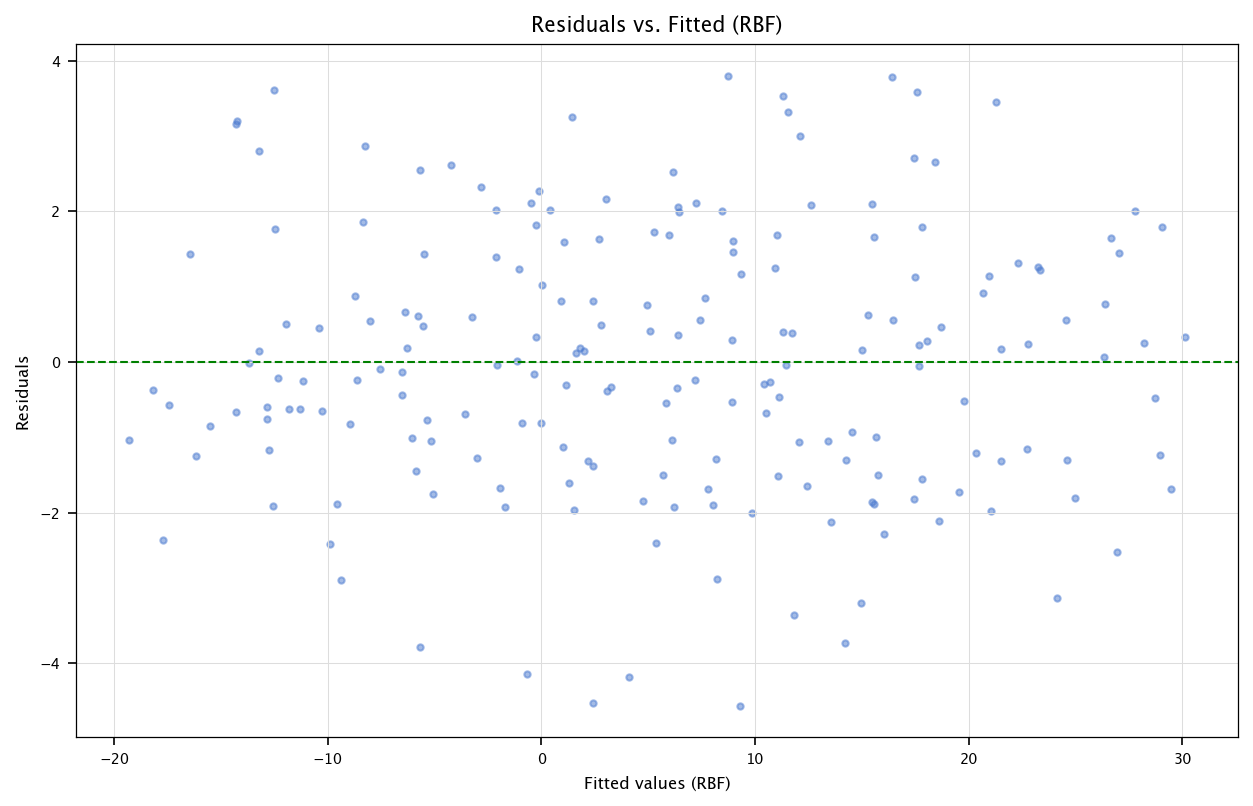

In [14]:
from sklearn.kernel_approximation import RBFSampler

rbf = RBFSampler(gamma=0.05, n_components=50, random_state=123)
X_rbf = rbf.fit_transform(df[['X1','X2','X3']])
print("RBF-transformed shape:", X_rbf.shape)

# We'll do OLS with statsmodels for brevity:
X_rbf_sm = sm.add_constant(X_rbf)
model_rbf_sm = sm.OLS(df['Y'], X_rbf_sm).fit()

print(model_rbf_sm.summary())

resid_rbf = model_rbf_sm.resid
fitted_rbf = model_rbf_sm.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_rbf, resid_rbf, alpha=0.5)
plt.axhline(y=0, color='green', linestyle='--')
plt.xlabel("Fitted values (RBF)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (RBF)")
plt.grid("on")
plt.show()

In [15]:
alpha_ridge = 10.0
I_p = np.eye(X_poly_mat.shape[1])  # dimension p x p, where p = number of poly features + 1 (intercept)

# Usually we do not regularize the intercept, so we might set I_p[0,0] = 0.
# Let's do that to avoid shrinking the intercept:
I_p[0,0] = 0.0

XTX_ridge = X_poly_mat.T @ X_poly_mat + alpha_ridge*I_p
XTX_ridge_inv = np.linalg.inv(XTX_ridge)
XTy_ridge = X_poly_mat.T @ y_vec
beta_hat_ridge_manual = XTX_ridge_inv @ XTy_ridge
beta_hat_ridge_manual = beta_hat_ridge_manual.flatten()

print("Manual Ridge (polynomial) shape:", beta_hat_ridge_manual.shape)
pprint("\\text{Manual Ridge Coeffs}:", beta_hat_ridge_manual)

Manual Ridge (polynomial) shape: (10,)


<IPython.core.display.Math object>

In [16]:
from sklearn.linear_model import Ridge

ridge_sklearn = Ridge(alpha=alpha_ridge, fit_intercept=False) 
# "fit_intercept=False" because we already included the intercept column in X_poly_mat
# We will manually set the intercept to match the first column or we can remove intercept from X_poly_mat.

ridge_sklearn.fit(X_poly_mat, df['Y'])
beta_hat_ridge_sklearn = ridge_sklearn.coef_

pprint("\\text{scikit-learn Ridge Coeffs}:", beta_hat_ridge_sklearn)
pprint("\\text{Difference (manual - sklearn)}:", (beta_hat_ridge_manual - beta_hat_ridge_sklearn))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

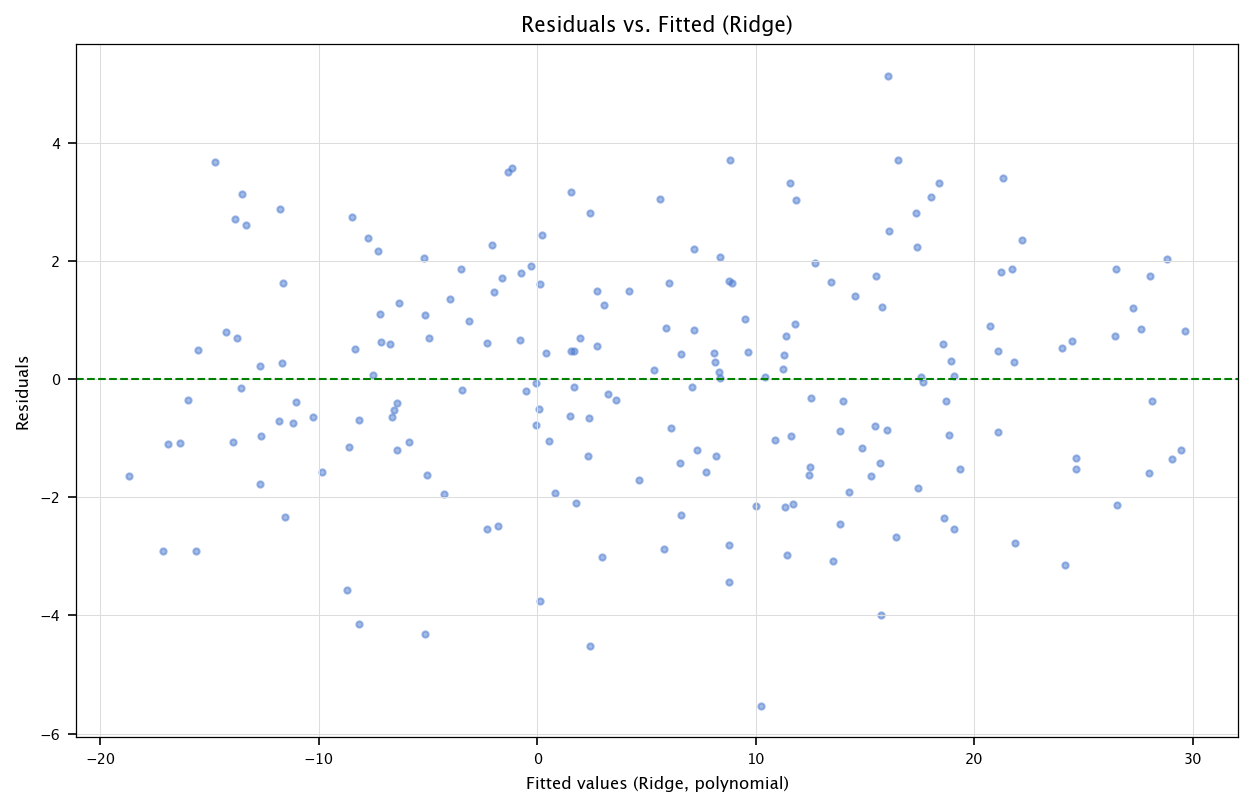

In [17]:
y_pred_ridge = X_poly_mat @ beta_hat_ridge_manual
resid_ridge = df['Y'] - y_pred_ridge

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, resid_ridge, alpha=0.5)
plt.axhline(y=0, color='g', linestyle='--')
plt.xlabel("Fitted values (Ridge, polynomial)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Ridge)")
plt.grid("on")
plt.show()